In [111]:
import numpy as np
import pandas as pd

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from torch import nn, optim
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

# set the seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# set display options
plt.rcParams["figure.figsize"] = (6, 4)
sns.set_style("darkgrid")

In [112]:
# define transformation
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# import MNNIST dataset
train_data = datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)
test_data = datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

# create dataloaders
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False)


In [113]:
# define the model
class factorized_linear(nn.Module):
    def __init__(self, in_features, rank, out_features):
        super(factorized_linear, self).__init__()
        self.in_features = in_features
        self.rank = rank
        self.out_features = out_features
        self.B = nn.Parameter(torch.Tensor(out_features, rank))
        self.A = nn.Parameter(torch.Tensor(rank, in_features))
        self.reset_parameters()
            
    def reset_parameters(self):
        nn.init.normal_(self.B, mean=0, std=0.01)
        nn.init.normal_(self.A, mean=0, std=0.01)
            
    def forward(self, x):
        return torch.mm(self.B, torch.mm(self.A, x.t())).t()

class FNN_Model(nn.Module):
    def __init__(self, in_features, rank, out_features):
        super(FNN_Model, self).__init__()
        self.in_features = in_features
        self.rank = rank
        self.out_features = out_features
        self.fc1 = factorized_linear(self.in_features, self.rank, 100)
        self.fc2 = factorized_linear(100, self.rank, 100)
        self.fc3 = factorized_linear(100, self.rank, self.out_features)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    


In [114]:
# Orthogonalization with Norm retention of col/row of the matrix
def orthogonalizeAB_with_norm_retention(A, B):
    # Compute the norms of A and B
    norm_B = torch.norm(B, p='fro', dim=0, keepdim=True)
    norm_A = torch.norm(A, p='fro', dim=1, keepdim=True)
    
    
    # Compute the SVD of A and B
    U_B, _, V_B = torch.svd(B)
    U_A, _, V_A = torch.svd(A)
    
    # Compute the orthogonalized matrices
    B_orth = torch.mm(U_B, V_B.T)
    A_orth = torch.mm(U_A, V_A.T)
    
    # Compute the norms of the orthogonalized matrices
    norm_B_orth = torch.norm(B_orth, p='fro', dim=0, keepdim=True)
    norm_A_orth = torch.norm(A_orth, p='fro', dim=1, keepdim=True)
    
    # Retain the norms of the original matrices
    B_orth = B_orth * (norm_B / norm_B_orth)
    A_orth = A_orth * (norm_A / norm_A_orth)
    
    return A_orth, B_orth

def orthogonalize_model(model):
    # Orthogonalize the matrices of the model
    model.fc1.A.data, model.fc1.B.data = orthogonalizeAB_with_norm_retention(model.fc1.A.data, model.fc1.B.data)
    model.fc2.A.data, model.fc2.B.data = orthogonalizeAB_with_norm_retention(model.fc2.A.data, model.fc2.B.data)
    model.fc3.A.data, model.fc3.B.data = orthogonalizeAB_with_norm_retention(model.fc3.A.data, model.fc3.B.data)
    return

In [115]:
def train(model, train_loader, optimizer, criterion, orth_proj=False, epochs=10):
    loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            if orth_proj:
                orthogonalize_model(model)

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, loss: {running_loss/len(train_loader)}")
        loss_history.append(running_loss / len(train_loader))
    print("Finished Training")
    return loss_history


def accuracy(model, loader):
    acc = Accuracy(
        task="multiclass", num_classes=10, multidim_average="global", average="none"
    )
    model.eval()
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            acc.update(outputs, labels)
    return acc.compute()


## Training without Orthogonalization

In [116]:
# define the model
model = FNN_Model(in_features=28 * 28, rank=5, out_features=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model [NO ORTHOGONALIZATION]
loss_history = train(model, train_loader, optimizer, criterion, orth_proj=False, epochs=10)

Epoch 1, loss: 1.7424281925789074
Epoch 2, loss: 1.5680151255146018
Epoch 3, loss: 1.5448964611807865
Epoch 4, loss: 1.2553517797481277
Epoch 5, loss: 0.9596252079203185
Epoch 6, loss: 0.8096014601843697
Epoch 7, loss: 0.704478288573751
Epoch 8, loss: 0.6072051461889292
Epoch 9, loss: 0.5566398713316745
Epoch 10, loss: 0.504817395608054
Finished Training


Train accuracy: tensor([94.8675, 94.7345, 79.7919, 85.4347, 89.7295, 77.7716, 92.8016, 90.5188,
        80.7554, 79.8958]) | Overall: 86.630126953125
Test accuracy: tensor([96.4286, 95.8590, 78.6822, 85.1485, 89.3075, 77.1300, 92.6931, 87.5486,
        78.7474, 79.2864]) | Overall: 86.08314514160156


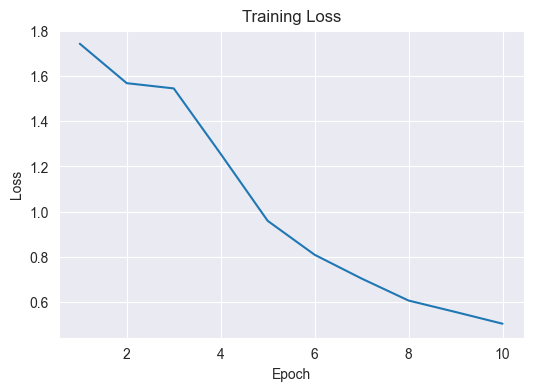

In [117]:
# test the model
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {train_accuracy*100} | Overall: {train_accuracy.mean()*100}")
print(f"Test accuracy: {test_accuracy*100} | Overall: {test_accuracy.mean()*100}")

# plot the loss history
plt.plot(range(1, 11), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

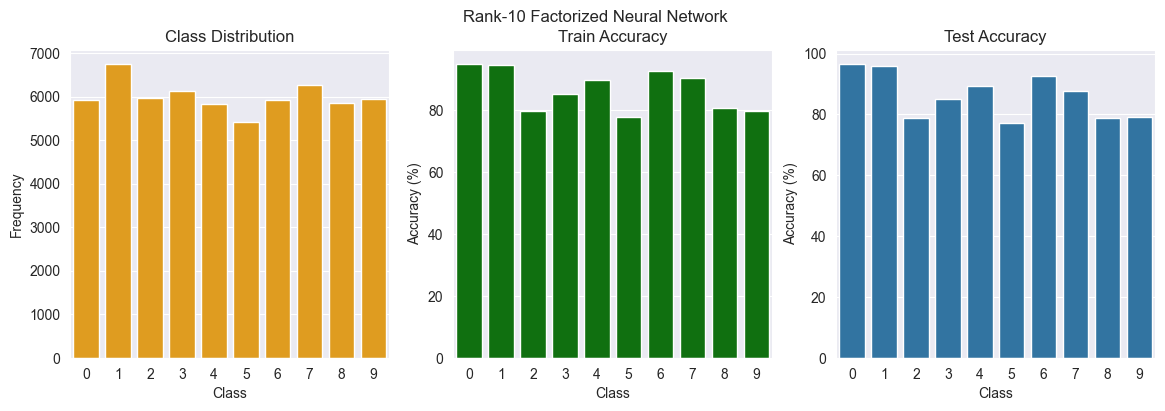

In [118]:
def plot_distributions_accuracies(title, classes, class_distribution, train_accuracy, test_accuracy):
    fig = plt.figure(figsize=(14, 4))
    fig.suptitle(title)

    plt.subplot(1, 3, 1)
    sns.barplot(x=classes, y=class_distribution, color="orange")
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Frequency")

    plt.subplot(1, 3, 2)
    sns.barplot(x=classes, y=train_accuracy*100, color="green")
    plt.title("Train Accuracy")
    plt.xlabel("Class")
    plt.ylabel("Accuracy (%)")

    plt.subplot(1, 3, 3)
    sns.barplot(x=classes, y=test_accuracy*100)
    plt.title("Test Accuracy")
    plt.xlabel("Class")
    plt.ylabel("Accuracy (%)")

    plt.show()
    

labels = train_data.targets.numpy()
classes, class_distribution = np.unique(labels, return_counts=True)
plot_distributions_accuracies("Rank-10 Factorized Neural Network", classes, class_distribution, train_accuracy, test_accuracy)

## Training with orthogonalization

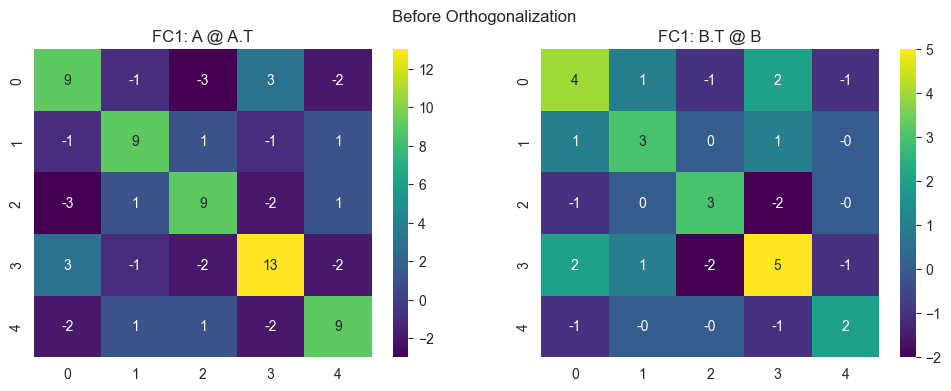

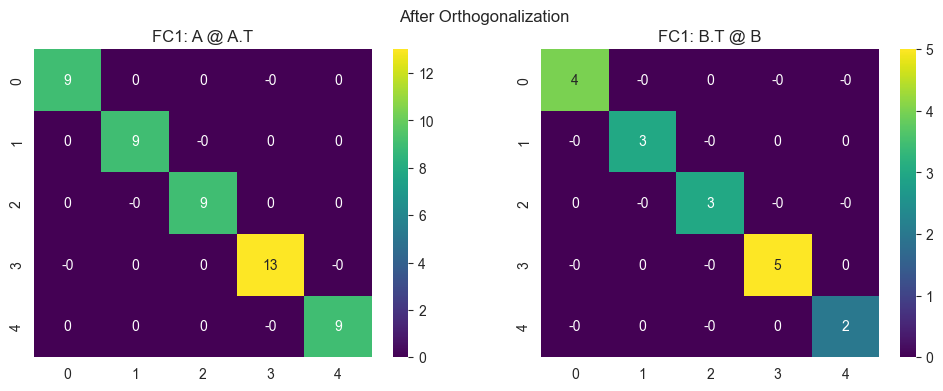

In [119]:
## Testing orthogonalization
model_copy = deepcopy(model)

fig = plt.figure(figsize=(12, 4))
fig.suptitle("Before Orthogonalization")
plt.subplot(1, 2, 1)
sns.heatmap(torch.round(model_copy.fc1.A @ model_copy.fc1.A.T).detach().numpy(), cmap="viridis", annot=True, fmt="g")
plt.title("FC1: A @ A.T")

plt.subplot(1, 2, 2)
sns.heatmap(torch.round(model_copy.fc1.B.T @ model_copy.fc1.B).detach().numpy(), cmap="viridis", annot=True, fmt="g")
plt.title("FC1: B.T @ B")

plt.show()

# Orthogonalize the model_copy
orthogonalize_model(model_copy)

fig = plt.figure(figsize=(12, 4))
fig.suptitle("After Orthogonalization")
plt.subplot(1, 2, 1)
sns.heatmap(torch.round(model_copy.fc1.A @ model_copy.fc1.A.T).detach().numpy(), cmap="viridis", annot=True, fmt="g")
plt.title("FC1: A @ A.T")

plt.subplot(1, 2, 2)
sns.heatmap(torch.round(model_copy.fc1.B.T @ model_copy.fc1.B).detach().numpy(), cmap="viridis", annot=True, fmt="g")
plt.title("FC1: B.T @ B")

plt.show()

In [120]:
# Train the model with orthogonalization
model_orth = FNN_Model(in_features=28 * 28, rank=5, out_features=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_orth.parameters(), lr=0.001)

# train the model [WITH ORTHOGONALIZATION]
loss_history_orth = train(model_orth, train_loader, optimizer, criterion, orth_proj=True, epochs=10)

Epoch 1, loss: 1.0167770102334175
Epoch 2, loss: 0.48446382550415457
Epoch 3, loss: 0.4328338518293936
Epoch 4, loss: 0.40138056127628535
Epoch 5, loss: 0.38362455307674814
Epoch 6, loss: 0.3665383392369061
Epoch 7, loss: 0.3552260414115401
Epoch 8, loss: 0.34515770725699374
Epoch 9, loss: 0.33597721950585907
Epoch 10, loss: 0.33258874058278637
Finished Training


Train accuracy: tensor([94.7999, 95.0608, 92.1954, 86.1360, 92.1602, 82.5493, 95.2011, 95.1955,
        86.8057, 86.3675]) | Overall: 90.64714050292969
Test accuracy: tensor([95.9184, 96.7401, 91.0853, 86.0396, 93.2790, 79.4843, 92.9019, 92.8016,
        84.3942, 86.7195]) | Overall: 89.93638610839844


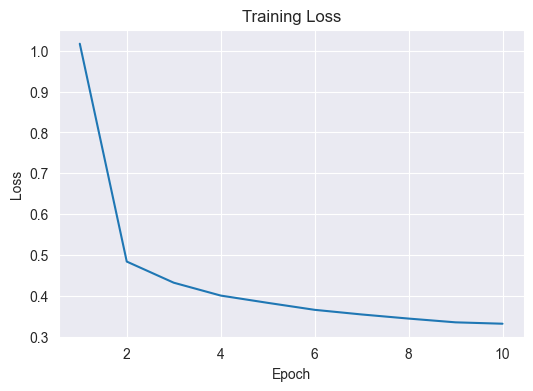

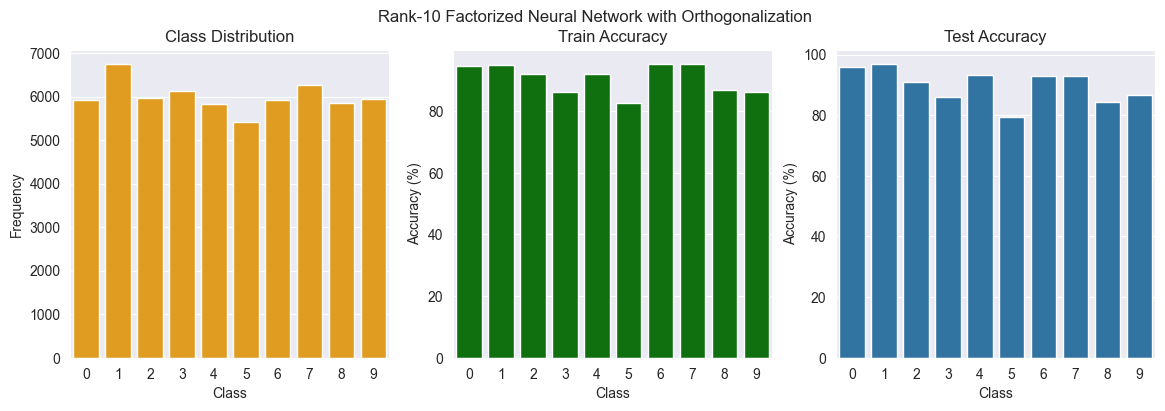

In [121]:
# test the model
train_accuracy_orth = accuracy(model_orth, train_loader)
test_accuracy_orth = accuracy(model_orth, test_loader)

print(f"Train accuracy: {train_accuracy_orth*100} | Overall: {train_accuracy_orth.mean()*100}")
print(f"Test accuracy: {test_accuracy_orth*100} | Overall: {test_accuracy_orth.mean()*100}")

# plot the loss history
plt.plot(range(1, 11), loss_history_orth)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

plot_distributions_accuracies("Rank-10 Factorized Neural Network with Orthogonalization", classes, class_distribution, train_accuracy_orth, test_accuracy_orth)

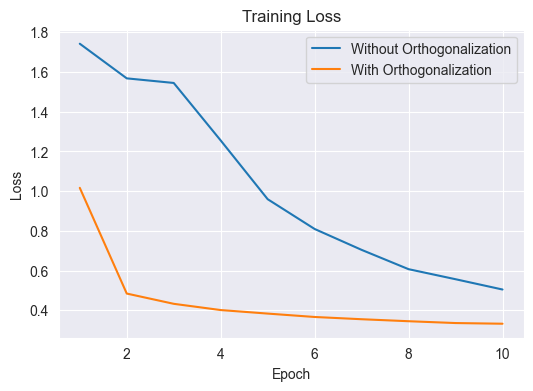

In [122]:
# Plot training loss history for both models
sns.lineplot(x=range(1, 11), y=loss_history, label="Without Orthogonalization")
sns.lineplot(x=range(1, 11), y=loss_history_orth, label="With Orthogonalization")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()


In [124]:
# Plot train and test accuracies for both models
accs = pd.DataFrame({
    "Model": ["Without Orthogonalization", "With Orthogonalization"],
    "Train Acc": [train_accuracy.mean().item()*100, train_accuracy_orth.mean().item()*100],
    "Test Acc": [test_accuracy.mean().item()*100, test_accuracy_orth.mean().item()*100]
})

accs

,Model,Train Acc,Test Acc
0,Without Orthogonalization,86.630124,86.083144
1,With Orthogonalization,90.647143,89.936388


# Combining models

In [7]:
# split dataset into 3 splits with mutually exclusive classes
splits_distribution = [
    np.array([0.1]*4 + [0.9]*6),
    np.array([0.8]*6 + [0.2]*4),
    np.array([0.1]*4 + [0.9]*4 + [0.1]*2)
]

split_indices = []

for i, split in enumerate(splits_distribution):
    chunk_class_dist = (class_distribution * split).astype(int)
    indices = []
    for idx in range(10):
        cls_indices = np.where(labels == idx)[0]
        indices.extend(np.random.choice(cls_indices, chunk_class_dist[idx], replace=False))
    split_indices.append(indices)
        
split_datasets = [Subset(train_data, indices) for indices in split_indices]

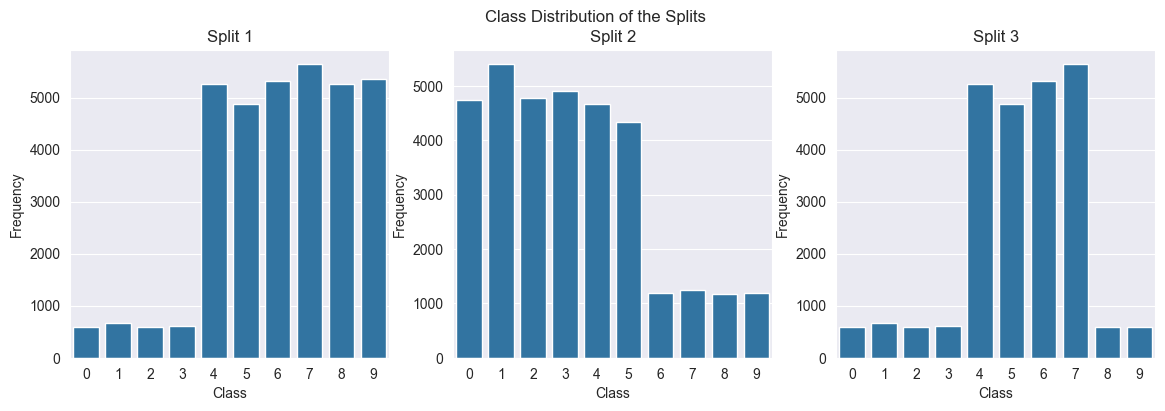

In [8]:
# Class distribution of the splits
fig = plt.figure(figsize=(14, 4))
fig.suptitle("Class Distribution of the Splits")

for i, split in enumerate(split_datasets):
    _, chunk_class_dist = np.unique(train_data.targets[split.indices].numpy(), return_counts=True)
    plt.subplot(1, 3, i+1)
    sns.barplot(x=classes, y=chunk_class_dist)
    plt.title(f"Split {i+1}")
    plt.xlabel("Class")
    plt.ylabel("Frequency")
    
plt.show()

In [9]:
# Dataloaders for each split
chunk_loaders = [DataLoader(dataset=split_data, batch_size=64, shuffle=True) for split_data in split_datasets]

# Train the model on each split
losses = []
split_models = []
split_train_accuracies = []
split_test_accuracies = []

# define the rank
r = 5

for i, split_loader in enumerate(chunk_loaders):
    print(f"--- Training on Split {i+1} ---")
    # define the model, criterion and optimizer
    model = FNN_Model(28 * 28, r, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # train the model
    loss_history = train(model, split_loader, optimizer, criterion, epochs=20)
    
    # evaluate the model
    train_accuracy = accuracy(model, split_loader)
    test_accuracy = accuracy(model, test_loader)
    
    # store the results
    losses.append(loss_history)
    split_models.append(model)
    split_train_accuracies.append(train_accuracy)
    split_test_accuracies.append(test_accuracy)


--- Training on Split 1 ---
Epoch 1, loss: 1.835541450865915
Epoch 2, loss: 1.2807434119910837
Epoch 3, loss: 0.862223223325248
Epoch 4, loss: 0.7318447951958559
Epoch 5, loss: 0.6833531966276258
Epoch 6, loss: 0.6452489247388928
Epoch 7, loss: 0.6024863250344713
Epoch 8, loss: 0.5192058307823734
Epoch 9, loss: 0.4579442578498448
Epoch 10, loss: 0.43204800919673153
Epoch 11, loss: 0.41653646748756695
Epoch 12, loss: 0.40780364781896644
Epoch 13, loss: 0.39739296829032006
Epoch 14, loss: 0.3873717377676028
Epoch 15, loss: 0.3785357071974567
Epoch 16, loss: 0.36138364236767045
Epoch 17, loss: 0.3478910559109438
Epoch 18, loss: 0.32658750265836717
Epoch 19, loss: 0.31018155445562345
Epoch 20, loss: 0.30288128448284674
Finished Training
--- Training on Split 2 ---
Epoch 1, loss: 1.8225493850363526
Epoch 2, loss: 1.554897429371968
Epoch 3, loss: 1.4444755800776607
Epoch 4, loss: 1.4113612683780292
Epoch 5, loss: 1.4054326412795615
Epoch 6, loss: 1.394848357135352
Epoch 7, loss: 1.3782466291

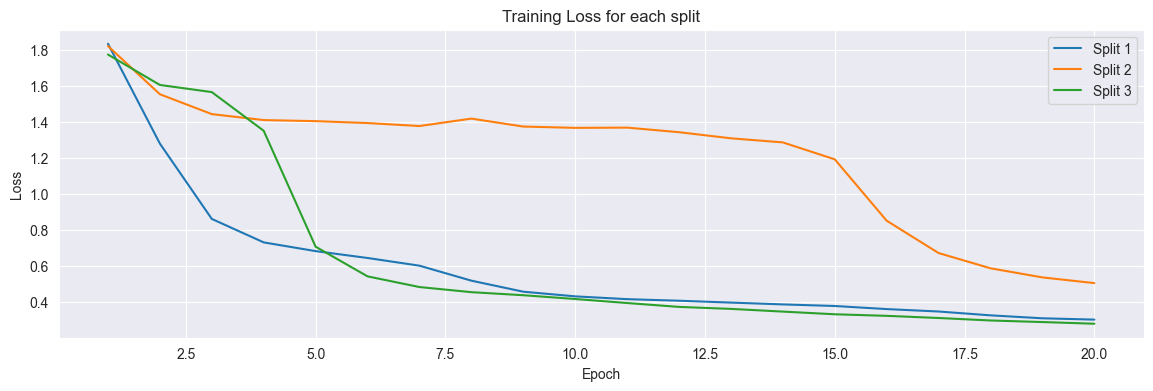

In [10]:
# plot the loss history
plt.figure(figsize=(14, 4))
for i in range(3):
    sns.lineplot(x=range(1, 21), y=losses[i], label=f"Split {i+1}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training Loss for each split")
plt.legend()
plt.show()

Split 1 - Train Accuracy: 83.23068237304688%


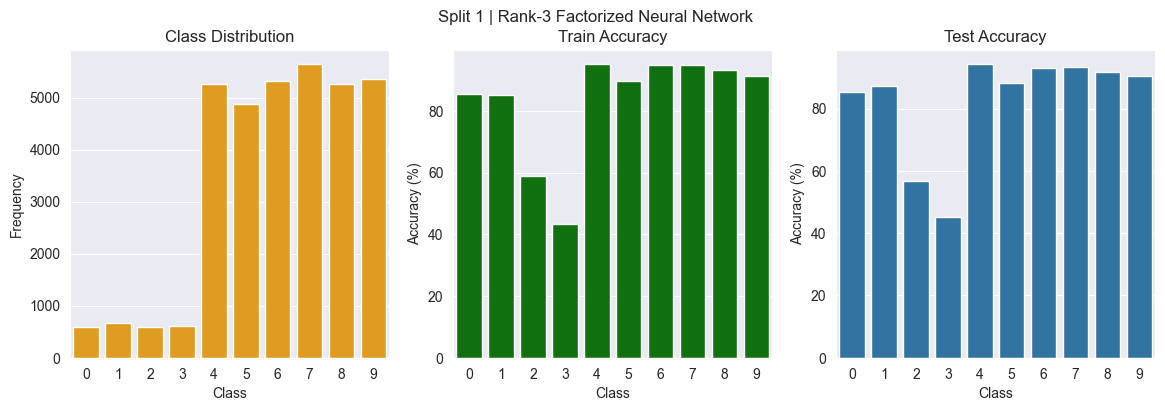

Split 2 - Train Accuracy: 77.86377716064453%


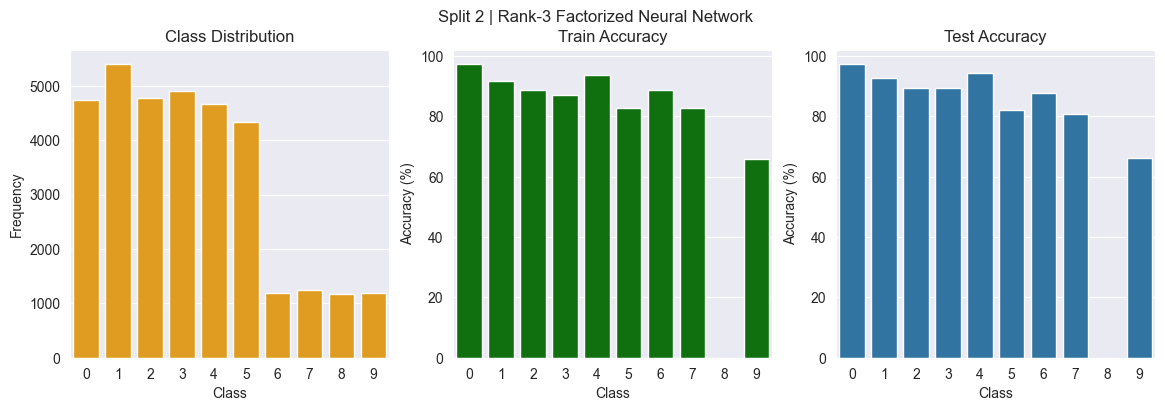

Split 3 - Train Accuracy: 78.95933532714844%


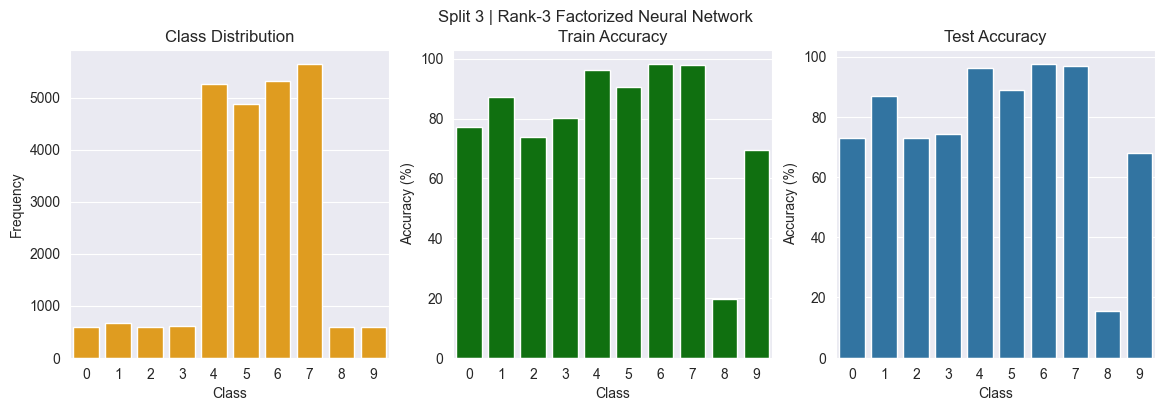

In [11]:
# plot the class distribution and accuracies
for i in range(3):
    classes, chunk_class_dist = np.unique(
        train_data.targets[split_datasets[i].indices].numpy(), return_counts=True
    )
    print(f"Split {i+1} - Train Accuracy: {split_train_accuracies[i].mean()*100}%")
    plot_distributions_accuracies(
        f"Split {i+1} | Rank-3 Factorized Neural Network",
        classes,
        chunk_class_dist,
        split_train_accuracies[i],
        split_test_accuracies[i],
    )

## Joining ranks

In [14]:
class FNN_Aggregate(nn.Module):
    def __init__(self, models):
        super(FNN_Aggregate, self).__init__()
        self.models = models
        self.in_features = models[0].in_features
        self.out_features = models[0].out_features
        self.fc1 = nn.Linear(self.in_features, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, self.out_features)
        self.set_weights()
    
    def set_weights(self):
        # set the weights of the aggregate model to be the average of the weights of the models
        self.fc1.weight.data.zero_()
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.zero_()
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.zero_()
        self.fc3.bias.data.zero_()
        
        for model in self.models:
            self.fc1.weight.data += (model.fc1.B @ model.fc1.A).detach()
            self.fc2.weight.data += (model.fc2.B @ model.fc2.A).detach()
            self.fc3.weight.data += (model.fc3.B @ model.fc3.A).detach()
        
        self.fc1.weight.data /= len(self.models)
        self.fc2.weight.data /= len(self.models)
        self.fc3.weight.data /= len(self.models)
        
        self.fc1.weight.requires_grad = True
        self.fc2.weight.requires_grad = True
        self.fc3.weight.requires_grad = True
        
    def forward(self, x):
        x = x.view(-1, self.in_features)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Train accuracy: 40.87897872924805
Test accuracy: 40.33605194091797


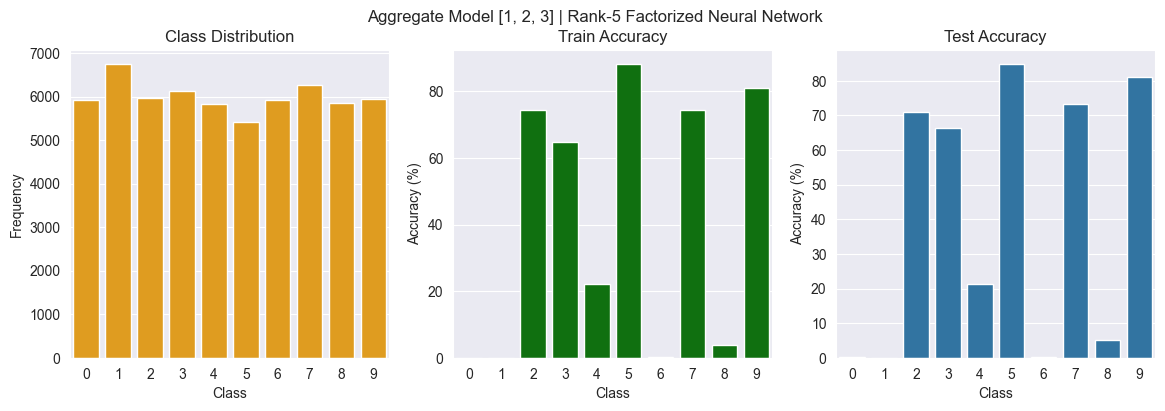

In [15]:
# create the aggregate model
aggregate_model = FNN_Aggregate(split_models)
# aggregate_model = FNN_Aggregate([split_models[0], split_models[2]])

# evaluate the aggregate model
train_accuracy = accuracy(aggregate_model, train_loader)
test_accuracy = accuracy(aggregate_model, test_loader)

print(f"Train accuracy: {train_accuracy.mean()*100}")
print(f"Test accuracy: {test_accuracy.mean()*100}")

# plot the class distribution and accuracies
plot_distributions_accuracies(
    "Aggregate Model [1, 2, 3] | Rank-5 Factorized Neural Network",
    classes,
    class_distribution,
    train_accuracy,
    test_accuracy,
)
